In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

def _wrp(row, model):
    s = simi.pairwise_cosine_similarity(simi.model_embeddings(model, [row["a"], row["p"], row["n"]]))[0]
    if s[1] > s[0]:
        return (*s, 0)
    return (*s, 1)

# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    ap_scores, an_scores, labels = zip(*df.progress_apply(lambda r: _wrp(r, model), axis=1))
    ap_scores = pd.Series(ap_scores, index=df.index, name=name+" a-p")
    an_scores = pd.Series(an_scores, index=df.index, name=name+" a-n")
    labels = pd.Series(labels, index=df.index, name="label")
    if append:
        df = df.merge(ap_scores.to_frame(), left_index=True, right_index=True)
        df = df.merge(an_scores.to_frame(), left_index=True, right_index=True)
        df = df.merge(labels.to_frame(), left_index=True, right_index=True)
        return df
    return ap_scores, an_scores, labels

2024-01-07 10:54:14.702040: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("anchor-arxiv-dataset.csv", index_col=0)
df.sample(5)

,title,abstract,categories,doi,a,p,n
73602,On the classification of metric hypercomplex g...,"In this article, the clarification to Note 4...","('math-ph', 'math.DG', 'math.MP', 'math.QA', '...",NaN,"In this article, the clarification to Note 4 ...",How technically to construct the symmetric con...,We describe necessary and sufficient conditio...
45324,A Coding-Theoretic Application of Baranyai's T...,Baranyai's theorem is a well-known theorem i...,"('cs.IT', 'math.IT')",NaN,"In this paper, we present a coding-theoretic a...",Locally decodable codes are error-correcting c...,We show the equivalence of this formulation to...
58229,O Algoritmo usado no programa de criptografia ...,This work present the main encryption's algo...,"('cs.CR', 'math.NT')",NaN,This software allows encrypt and hide an infor...,The algorithm uses the fact that factoring lar...,In this paper we prove an Ax-Schanuel type re...
91254,Online change-point detection for a transient ...,We consider a popular online change-point pr...,"('math.ST', 'stat.TH')",NaN,We consider a popular online change-point pro...,"For this change-point problem, several change-...",The data satisfy an ergodicity criterion which...
51656,Quantum curves and topological recursion,This is a survey article describing the rela...,"('math-ph', 'math.AG', 'math.MP', 'math.QA')",NaN,This is a survey article describing the relat...,"The Schr\""odinger operator annihilates a wave ...",Bounded analytical solutions are represented u...


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 73760 eval: 9221 test: 9221


## Model definitions

In [4]:
# Prerequisites for the models
bert_base = models.Transformer('bert-base-uncased')
mathbert_base = models.Transformer('witiko/mathberta')
#bert_finetune_base = models.Transformer("./bert+fine-tune_classi_class_zbmath", tokenizer_name_or_path="bert-base-uncased")
bert_mlm_base = models.Transformer("./bert+re-train_mlm_abstracts_arxiv")
specter2_base = models.Transformer('allenai/specter2_base')

# Definition of models that are evaluated
# combine models into dict
eval_models = {
    "Bert+CLS": SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Bert+MP": SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension())]),
    
    "SBert-MpNet": SentenceTransformer('all-mpnet-base-v2'),
    "SBert-DistilRoberta": SentenceTransformer('all-distilroberta-v1'),
    "SBert-MiniLM-L12": SentenceTransformer('all-MiniLM-L12-v2'),
    "SBert-MiniLM-L6": SentenceTransformer('all-MiniLM-L6-v2'),
    
    "Mathbert+CLS": SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Mathbert+MP": SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension())]),
    
    "Specter 2+CLS": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Specter 2+MP": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension())]),
    
    "SGPT": SentenceTransformer('Muennighoff/SGPT-125M-weightedmean-nli-bitfit'),
    
    "Bert+MLM+CLS": SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Bert+MLM+MP": SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension())]),

    "Bert+TSDAE+CLS": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv'),
    "Bert+TSDAE+MP": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv'),
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at witiko/mathberta were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["a"], r["p"], r["n"]]), axis=1)
evaluator = evaluation.TripletEvaluator.from_input_examples(eval_examples, batch_size=64, main_distance_function=0, show_progress_bar=True)

In [6]:
%%time
eval_results = {}

with tqdm(total=len(eval_models), desc="Models") as pb:
    for n,m in eval_models.items():
        eval_results[n] = [m.evaluate(evaluator)]
        pb.update()

eval_result_df = pd.DataFrame(eval_results)

Models:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

CPU times: user 37min 20s, sys: 1min 52s, total: 39min 12s
Wall time: 11min 11s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
eval_result_df

,Bert+CLS,Bert+MP,SBert-MpNet,SBert-DistilRoberta,SBert-MiniLM-L12,SBert-MiniLM-L6,Mathbert+CLS,Mathbert+MP,Specter 2+MP,Specter 2+CLS,SGPT,Bert+MLM+CLS,Bert+MLM+MP,Bert+TSDAE+CLS,Bert+TSDAE+MP
0,0.679644,0.720312,0.87073,0.862488,0.868561,0.863355,0.785056,0.732242,0.831689,0.865633,0.778115,0.829303,0.807396,0.841991,0.831255


## Cosine-Similarity for test data

In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        ap_scores, an_scores, labels = st_similarity_scoring(X_test, m)
        X_test_score["cos-sim (a--p {})".format(n)] = ap_scores
        X_test_score["cos-sim (a--n {})".format(n)] = an_scores
        X_test_score["label ({})".format(n)] = labels
        pb.update()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

CPU times: user 1h 53min 56s, sys: 1min 43s, total: 1h 55min 39s
Wall time: 38min 36s


In [11]:
X_test_score.describe()

,cos-sim (a--p Bert+CLS),cos-sim (a--n Bert+CLS),label (Bert+CLS),cos-sim (a--p Bert+MP),cos-sim (a--n Bert+MP),label (Bert+MP),cos-sim (a--p SBert-MpNet),cos-sim (a--n SBert-MpNet),label (SBert-MpNet),cos-sim (a--p SBert-DistilRoberta),cos-sim (a--n SBert-DistilRoberta),label (SBert-DistilRoberta),cos-sim (a--p SBert-MiniLM-L12),cos-sim (a--n SBert-MiniLM-L12),label (SBert-MiniLM-L12),cos-sim (a--p SBert-MiniLM-L6),cos-sim (a--n SBert-MiniLM-L6),label (SBert-MiniLM-L6),cos-sim (a--p Mathbert+CLS),cos-sim (a--n Mathbert+CLS),...,cos-sim (a--n Specter 2+MP),label (Specter 2+MP),cos-sim (a--p Specter 2+CLS),cos-sim (a--n Specter 2+CLS),label (Specter 2+CLS),cos-sim (a--p SGPT),cos-sim (a--n SGPT),label (SGPT),cos-sim (a--p Bert+MLM+CLS),cos-sim (a--n Bert+MLM+CLS),label (Bert+MLM+CLS),cos-sim (a--p Bert+MLM+MP),cos-sim (a--n Bert+MLM+MP),label (Bert+MLM+MP),cos-sim (a--p Bert+TSDAE+CLS),cos-sim (a--n Bert+TSDAE+CLS),label (Bert+TSDAE+CLS),cos-sim (a--p Bert+TSDAE+MP),cos-sim (a--n Bert+TSDAE+MP),label (Bert+TSDAE+MP)
count,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,...,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000
mean,0.864638,0.835176,0.678885,0.822677,0.770143,0.720312,0.457494,0.223165,0.870730,0.416264,0.192926,0.862488,0.401429,0.169546,0.868561,0.415165,0.186652,0.863355,0.996601,0.995328,...,0.815929,0.829736,0.900244,0.857090,0.864548,0.538594,0.420283,0.778115,0.810288,0.719492,0.816180,0.822639,0.765077,0.807396,0.645323,0.545667,0.841991,0.456720,0.320898,0.831255
std,0.059697,0.065826,0.466930,0.084066,0.090532,0.448870,0.182523,0.126491,0.335517,0.179958,0.115555,0.344406,0.185456,0.110599,0.337898,0.185462,0.115733,0.343490,0.001318,0.001565,...,0.040428,0.375885,0.030460,0.028558,0.342224,0.139131,0.115819,0.415537,0.078293,0.091052,0.387358,0.062712,0.055442,0.394366,0.086431,0.060051,0.364769,0.120239,0.085922,0.374547
min,0.442805,0.347301,0.000000,0.366635,0.267583,0.000000,-0.085114,-0.154806,0.000000,-0.164175,-0.135951,0.000000,-0.096802,-0.128056,0.000000,-0.093963,-0.146643,0.000000,0.987461,0.986363,...,0.532872,0.000000,0.782398,0.751270,0.000000,0.015186,-0.142309,0.000000,0.251046,0.272181,0.000000,0.515531,0.505978,0.000000,0.374408,0.331516,0.000000,0.009173,-0.029156,0.000000
25%,0.836499,0.802660,0.000000,0.779907,0.719164,0.000000,0.328314,0.131625,1.000000,0.284512,0.109982,1.000000,0.261365,0.090590,1.000000,0.282511,0.103769,1.000000,0.995949,0.994458,...,0.793270,1.000000,0.879644,0.838368,1.000000,0.446909,0.343521,1.000000,0.766136,0.661974,1.000000,0.785317,0.732152,1.000000,0.583399,0.505089,1.000000,0.371657,0.263025,1.000000
50%,0.876011,0.846965,1.000000,0.840718,0.787745,1.000000,0.454467,0.219934,1.000000,0.412118,0.188638,1.000000,0.395923,0.164560,1.000000,0.411396,0.180997,1.000000,0.996815,0.995553,...,0.819638,1.000000,0.900789,0.858301,1.000000,0.545963,0.426099,1.000000,0.823499,0.726541,1.000000,0.828711,0.769073,1.000000,0.643994,0.544619,1.000000,0.453030,0.321107,1.000000
75%,0.906062,0.881429,1.000000,0.882991,0.837665,1.000000,0.589940,0.309593,1.000000,0.546174,0.271456,1.000000,0.534041,0.242826,1.000000,0.547364,0.263229,1.000000,0.997514,0.996460,...,0.843116,1.000000,0.921387,0.876628,1.000000,0.639397,0.499931,1.000000,0.866662,0.785614,1.000000,0.866696,0.803771,1.000000,0.704933,0.585202,1.000000,0.535897,0.377792,1.000000
max,0.982653,0.967612,1.000000,0.991527,0.957858,1.000000,0.966644,0.662535,1.000000,0.942945,0.631603,1.000000,0.957563,0.660089,1.000000,0.962417,0.640339,1.000000,0.999570,0.998750,...,0.957635,1.000000,0.985858,0.967795,1.000000,0.952178,0.872462,1.000000,

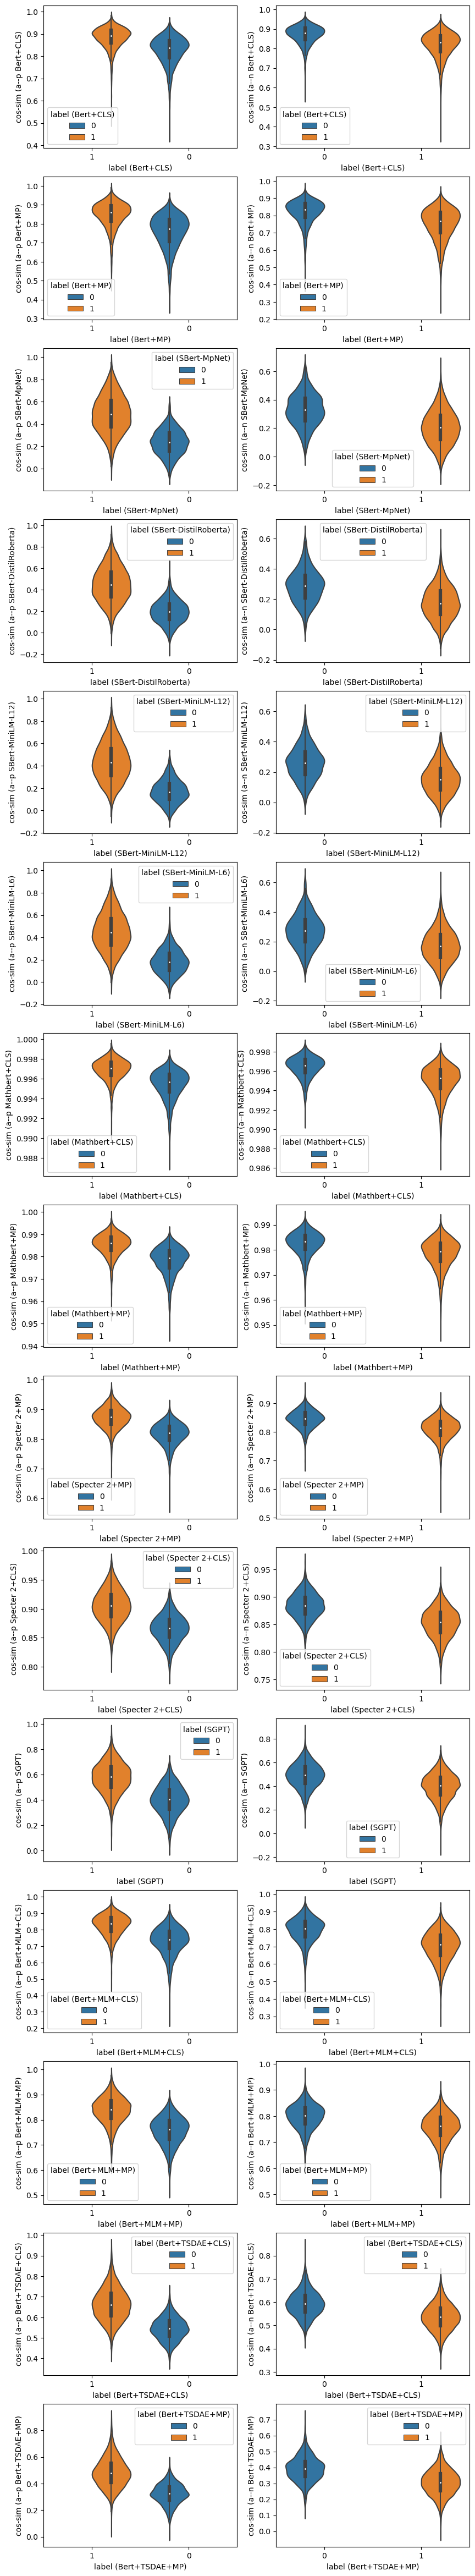

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 2, figsize=(10, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.violinplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--p {})".format(n), hue="label ({})".format(n), order=[1, 0], scale="count", scale_hue=True, ax=axs[i][0])
    sns.violinplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--n {})".format(n), hue="label ({})".format(n), scale="count", scale_hue=True, ax=axs[i][1])

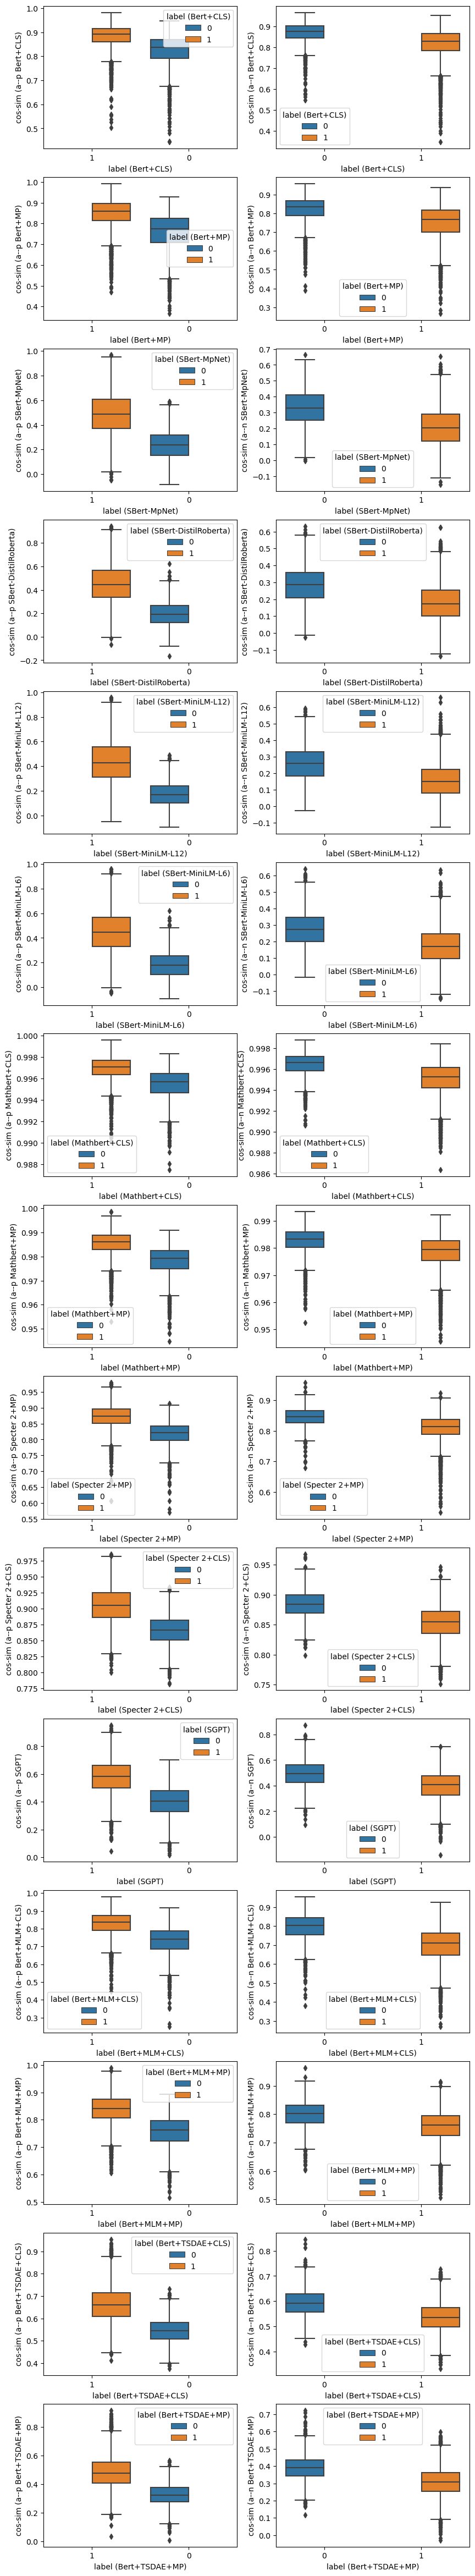

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 2, figsize=(10, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--p {})".format(n), hue="label ({})".format(n), order=[1, 0], ax=axs[i][0])
    sns.boxplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--n {})".format(n), hue="label ({})".format(n), ax=axs[i][1])

## Results for test data

In [14]:
X_test_score.sample(15, random_state=RANDOM_STATE)

,title,abstract,categories,doi,a,p,n,cos-sim (a--p Bert+CLS),cos-sim (a--n Bert+CLS),label (Bert+CLS),cos-sim (a--p Bert+MP),cos-sim (a--n Bert+MP),label (Bert+MP),cos-sim (a--p SBert-MpNet),cos-sim (a--n SBert-MpNet),label (SBert-MpNet),cos-sim (a--p SBert-DistilRoberta),cos-sim (a--n SBert-DistilRoberta),label (SBert-DistilRoberta),cos-sim (a--p SBert-MiniLM-L12),...,cos-sim (a--n Specter 2+MP),label (Specter 2+MP),cos-sim (a--p Specter 2+CLS),cos-sim (a--n Specter 2+CLS),label (Specter 2+CLS),cos-sim (a--p SGPT),cos-sim (a--n SGPT),label (SGPT),cos-sim (a--p Bert+MLM+CLS),cos-sim (a--n Bert+MLM+CLS),label (Bert+MLM+CLS),cos-sim (a--p Bert+MLM+MP),cos-sim (a--n Bert+MLM+MP),label (Bert+MLM+MP),cos-sim (a--p Bert+TSDAE+CLS),cos-sim (a--n Bert+TSDAE+CLS),label (Bert+TSDAE+CLS),cos-sim (a--p Bert+TSDAE+MP),cos-sim (a--n Bert+TSDAE+MP),label (Bert+TSDAE+MP)
68558,Consumption investment optimization with Epste...,In a market with stochastic investment oppor...,"('math.PR', 'q-fin.PM')",NaN,The empirically relevant utility specification...,In a market with stochastic investment opport...,"In the second part, we establish the solvabili...",0.897587,0.872767,1,0.852892,0.811638,1,0.458634,0.237280,1,0.448649,0.200009,1,0.550817,...,0.849342,1,0.919528,0.865443,1,0.493385,0.348288,1,0.839522,0.728224,1,0.814483,0.728986,1,0.682900,0.494133,1,0.513993,0.222125,1
61220,The Brauer-Manin obstruction for stacky curves,We show that the Brauer-Manin obstruction is...,"('math.AG', 'math.NT')",NaN,We will furthermore show that the elementary o...,We then compute the Brauer-Manin obstruction f...,Conjectures involving infinite families of re...,0.954089,0.869877,1,0.947043,0.849729,1,0.870660,0.243040,1,0.807377,0.195894,1,0.807803,...,0.822451,1,0.950853,0.839928,1,0.606856,0.408088,1,0.933857,0.642576,1,0.917799,0.763042,1,0.862127,0.475699,1,0.772743,0.304774,1
34522,Extending wavelet filters. Infinite dimensions...,In this paper we are discussing various aspe...,"('math.CV', 'math.FA')",NaN,"We focus on the non-rational case, and establi...","Motivated by applications, and by bringing to ...",We establish system of equations for single f...,0.950646,0.818908,1,0.943743,0.774461,1,0.370614,0.218570,1,0.408029,0.204916,1,0.426774,...,0.843082,1,0.905636,0.881047,1,0.624446,0.477960,1,0.830783,0.778067,1,0.888132,0.819347,1,0.706585,0.541275,1,0.538442,0.349666,1
54170,Michel theory of symmetry breaking and gauge t...,We extend Michel's theorem on the geometry o...,"('math-ph', 'math.MP')",10.1006/aphy.1997.5700,of gauge-invariant functionals defined on the ...,We extend Michel's theorem on the geometry of...,We study the anisotropic version of the Hasti...,0.671227,0.796411,0,0.787112,0.793979,0,0.200590,0.211525,0,0.159492,0.105835,1,0.107559,...,0.842086,0,0.843716,0.882468,0,0.507873,0.423263,1,0.802562,0.796279,1,0.736171,0.744121,0,0.451795,0.535725,0,0.252331,0.387827,0
55184,Convergence Analysis of Virtual Element Method...,"In this article, we have considered a nonlin...","('math.NA', 'cs.NA', 'math.AP')",NaN,"Finally, numerical experiments are presented t...",We employ VEM to discretize the space variable...,For this second class of problems a special ve...,0.823456,0.840494,0,0.647312,0.738889,0,0.472123,0.303205,1,0.374902,0.132639,1,0.372525,...,0.794735,1,0.918455,0.860593,1,0.382023,0.526735,0,0.890313,0.674238,1,0.763095,0.748482,1,0.629021,0.623182,1,0.476332,0.458717,1
24020,Simion's type $B$ associahedron is a pulling t...,We show that Simion's type $B$ associahedron...,"('math.CO',)",NaN,"Finally, we present a bijection between the fa...","Furthermore, we show that every pulling triang...",This class contains all matroidal and stable i...,0.767527,0.824674,0,0.549842,0.496749,1,0.391644,0.273469,1,0.394440,0.248094,1,0.367850,...,0.839086,1,0.908414,0.872773,1,0.344632,0.209420,1,0.920021,0.836294,1,0.870981,0.713557,1,0.545049,0.547891,0,0.308561,0.318307,0
21021,The expected degree of noninvertibility of com...,"Recently